Acurácia do Voting Classifier: 0.74


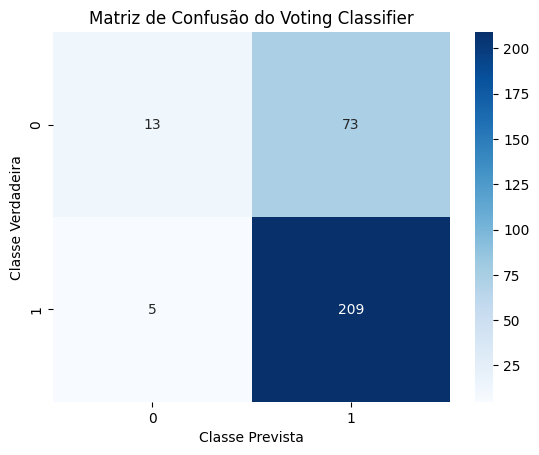

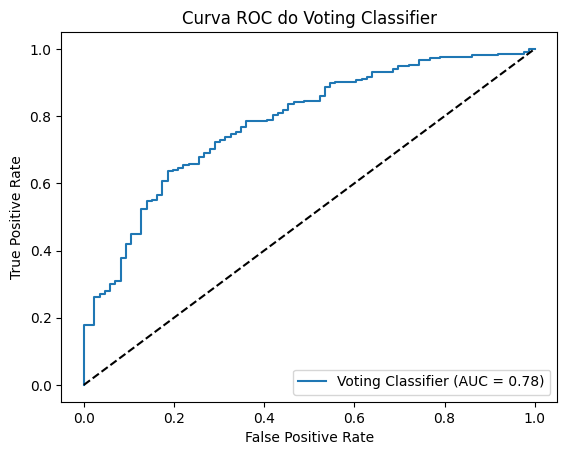

checking_status: 0.1040
credit_amount: 0.0821
duration: 0.0794
credit_history: 0.0709
age: 0.0684
purpose: 0.0612
savings_status: 0.0539
installment_commitment: 0.0536
employment: 0.0516
residence_since: 0.0489
property_magnitude: 0.0467
personal_status: 0.0439
other_payment_plans: 0.0425
job: 0.0410
housing: 0.0347
own_telephone: 0.0318
existing_credits: 0.0317
other_parties: 0.0267
num_dependents: 0.0209
foreign_worker: 0.0061


C:\Users\55219\AppData\Local\Temp\ipykernel_14116\1351983553.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[1] for x in atributos_importantes], y=[x[0] for x in atributos_importantes], palette='Blues_d')


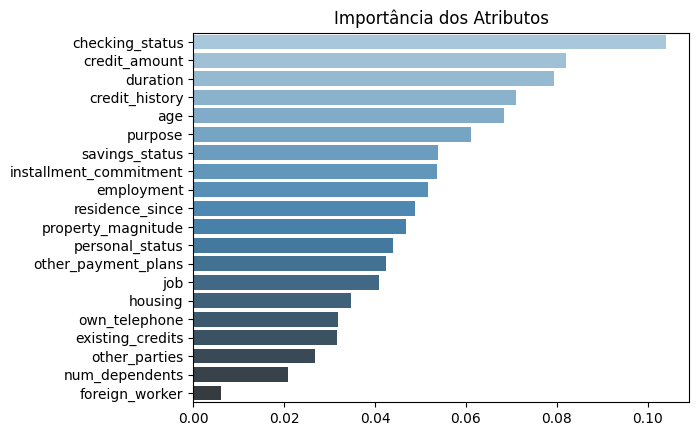

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier

credit = pd.read_csv('Credit.csv')

nomes_colunas = credit.columns
previsores = credit.iloc[:, 0:20].values
classe = credit.iloc[:, 20].values

label_encoder = LabelEncoder()
categorical_indices = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
for index in categorical_indices:
    previsores[:, index] = label_encoder.fit_transform(previsores[:, index])

X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores, classe, test_size=0.3, random_state=1)

svm = SVC(probability=True, random_state=42)
svm.fit(X_treinamento, y_treinamento)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_treinamento, y_treinamento)

voting_model = VotingClassifier(estimators=[
    ('svm', SVC(probability=True, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
], voting='soft')

voting_model.fit(X_treinamento, y_treinamento)

previsoes_voting = voting_model.predict(X_teste)

taxa_acerto_voting = accuracy_score(y_teste, previsoes_voting)
print(f'Acurácia do Voting Classifier: {taxa_acerto_voting:.2f}')


conf_matrix = confusion_matrix(y_teste, previsoes_voting)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão do Voting Classifier')
plt.show()


y_prob_voting = voting_model.predict_proba(X_teste)[:, 1]

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_teste, y_prob_voting, pos_label='good')
roc_auc = roc_auc_score(y_teste, y_prob_voting)

plt.figure()
plt.plot(fpr, tpr, label=f'Voting Classifier (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC do Voting Classifier')
plt.legend(loc='lower right')
plt.show()


forest = ExtraTreesClassifier(random_state=42)
forest.fit(X_treinamento, y_treinamento)
importancias = forest.feature_importances_

atributos_importantes = sorted(zip(nomes_colunas[:-1], importancias), key=lambda x: x[1], reverse=True)
for atributo, importancia in atributos_importantes:
    print(f'{atributo}: {importancia:.4f}')

sns.barplot(x=[x[1] for x in atributos_importantes], y=[x[0] for x in atributos_importantes], palette='Blues_d')
plt.title('Importância dos Atributos')
plt.show()


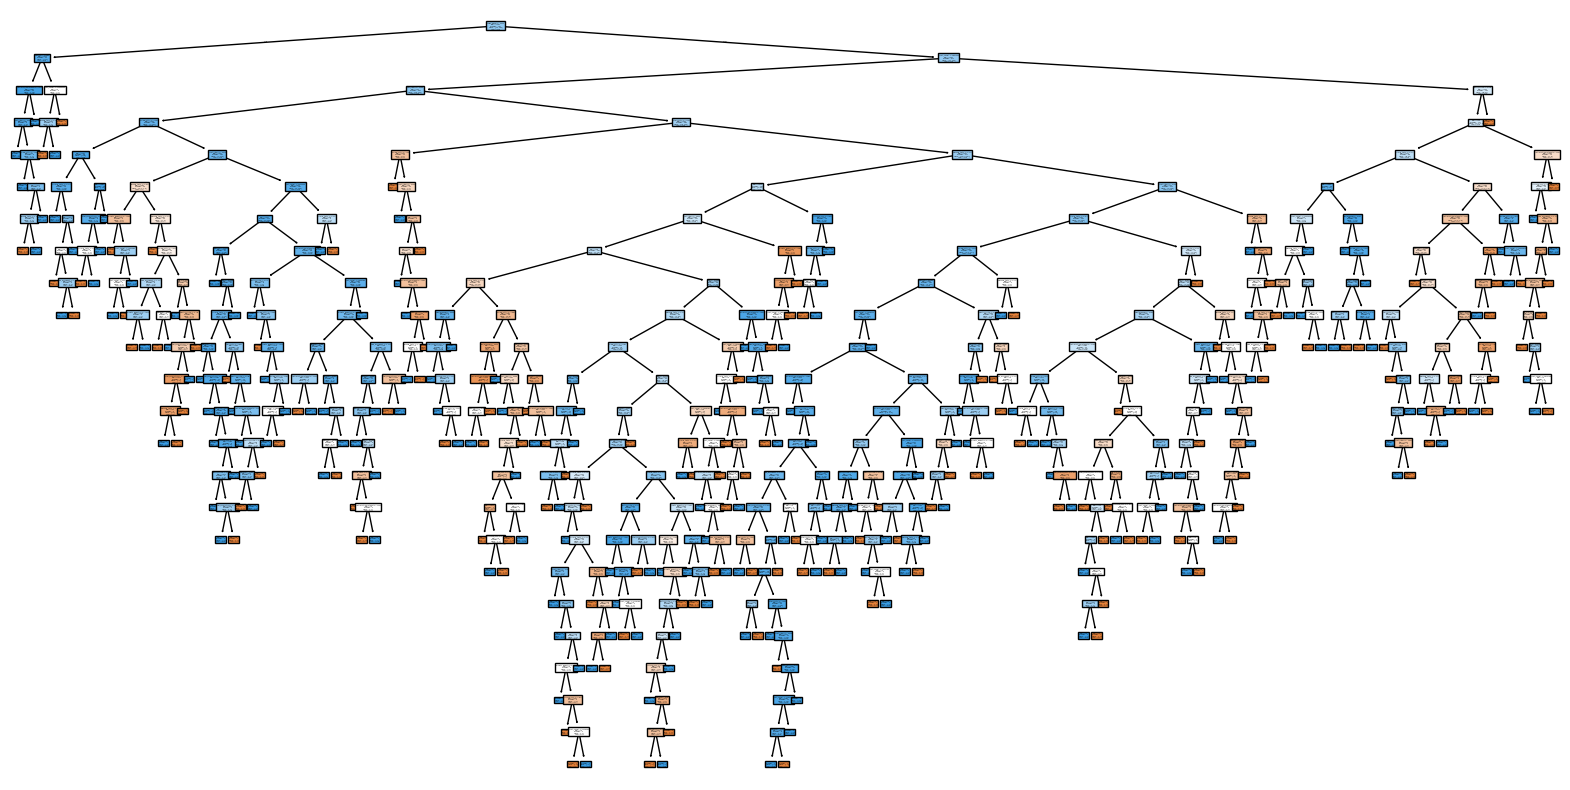

In [12]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(forest.estimators_[0], feature_names=nomes_colunas[:-1], class_names=forest.classes_, filled=True)
plt.show()
